Python version used: **3.9.13**

Imports:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import csv
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

Check that cuda is available (when using my own system):

In [2]:
torch.cuda.is_available()

True

# Q1:

(a)

In [4]:
with open("PADL-Q1.csv") as q1_file:
  q1_data = []
  q1_dataset = csv.reader(q1_file, delimiter=',')
  for row in q1_dataset:
    if row[0] != 'x1':
      q1_data.append(row)

In [5]:
pca = PCA(n_components=5)
pca.fit(q1_data)
newData = pca.fit_transform(q1_data)
pca_var_percentage = pca.explained_variance_ratio_
print(pca_var_percentage)

[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]


In [6]:
three_dims = pca_var_percentage[0]+pca_var_percentage[1]+pca_var_percentage[2]
print("Information retained with 3 variables = %f%%\n"%(three_dims*100.0))
print("Information retained with 4 variables = %f%%"%((three_dims + pca_var_percentage[3])*100.0))

Information retained with 3 variables = 94.177351%

Information retained with 4 variables = 98.783177%


Reducing the dimensionality of the dataset by 1 dimension causes information loss of 1.22%. Reducing it by 2 dimensions (down to 3) causes information loss of 5.82% however it is now possible to plot the dataset on a 3D axis, whereas this is not possible with 4 dimensions. Therefore, D_min = 3.





(b)

In [7]:
pca2 = PCA(n_components=3)
pca2.fit(q1_data)
newData2 = pca2.fit_transform(q1_data)
pca2_components = pca2.components_

In [8]:
for line in pca2_components:
    print("%f*x1 + %f*x2 + %f*x3 + %f*x4 + %f*x5\n"%(line[0],line[1],line[2],line[3],line[4]))

-0.092819*x1 + 0.025272*x2 + -0.348770*x3 + 0.145083*x4 + -0.920900*x5

0.005624*x1 + -0.298705*x2 + -0.114221*x3 + -0.940623*x4 + -0.113695*x5

0.112668*x1 + -0.133156*x2 + 0.914203*x3 + -0.023934*x4 + -0.365014*x5



# Q2:

Read data into a Pandas Dataframe:

In [10]:
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data

,x,y,z,w,out
0,66.4774,1.6495,0.7613,0.1,-0.0209
1,15.1422,2.2292,0.0050,0.1,0.1281
2,87.9859,2.1449,0.2217,0.1,0.1289
3,79.4979,2.0901,0.0396,0.1,0.1442
4,36.5181,2.0992,0.2040,0.0,-0.0131
...,...,...,...,...,...
75,7.5622,2.2608,0.0785,0.1,0.3158
76,10.7811,2.0351,0.6939,0.1,0.0325
77,57.3595,2.2470,0.3667,0.0,0.0675
78,4.4803,1.6897,0.0544,0.1,0.3627


Split into train and test data:

In [11]:
X = q2_data.drop('out', axis=1)
y = q2_data['out']
# Split 70:10 train:test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.125)

Fit a LR model, compare predicted vs actual values, calculate R2 score:

In [12]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

r2 = r2_score(y_test,y_pred)

for y1,y2 in zip(y_test,y_pred):
    print(f'Predicted vs actual: {y2:.4f} vs {y1}')

print(f'\nR2 score: {r2:.6f}')

Predicted vs actual: -0.1197 vs -0.1023
Predicted vs actual: 0.0888 vs 0.0547
Predicted vs actual: -0.0532 vs -0.1009
Predicted vs actual: -0.0068 vs 0.2046
Predicted vs actual: 0.0493 vs 0.0325
Predicted vs actual: 0.0395 vs -0.0369
Predicted vs actual: 0.0910 vs 0.202
Predicted vs actual: 0.0541 vs 0.0328
Predicted vs actual: -0.0323 vs -0.0613
Predicted vs actual: -0.0235 vs 0.1666

R2 score: 0.171847


# Q3:

In [ ]:
# code

# Q4:

Define MLP using Fully Connected and ReLU layers only:

In [13]:
class MultiplyMLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(MultiplyMLP, self).__init__()
        self.linear1 = nn.Linear(inputSize,hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize,1)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Function to generate random training data in the range [-100,100):

In [14]:
def generate_data(low,high,num_samples):
    x1 = np.random.uniform(low,high, num_samples)
    x2 = np.random.uniform(low,high, num_samples)
    y_true = x1 * x2
    data = torch.tensor(np.column_stack((x1, x2))).to(torch.float32)
    labels = torch.tensor(y_true).reshape(-1, 1)
    return data, labels

Run training loop to train on random data:

In [15]:
# Define hyperparameters
input_size = 2
hidden_size = 64
learning_rate = 0.01
num_epochs = 2500
batch_size = 32
num_samples = 3000
# Use L1Loss for absolute error
criterion = nn.L1Loss()

model = MultiplyMLP(input_size,hidden_size)
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# Create list to store loss values in for plotting
losses = []

for epoch in range(num_epochs):
    for i in range(0,num_samples,batch_size):
        data,labels = generate_data(-100,100,batch_size)

        output = model(data)
        loss = criterion(output, labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    if (epoch+1) % 250 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())



Epoch [250/2500], Loss: 550.3014
Epoch [500/2500], Loss: 49.3644
Epoch [750/2500], Loss: 34.6003
Epoch [1000/2500], Loss: 25.2541
Epoch [1250/2500], Loss: 28.7360
Epoch [1500/2500], Loss: 22.7112
Epoch [1750/2500], Loss: 24.3826
Epoch [2000/2500], Loss: 20.1626
Epoch [2250/2500], Loss: 16.9684
Epoch [2500/2500], Loss: 31.4864


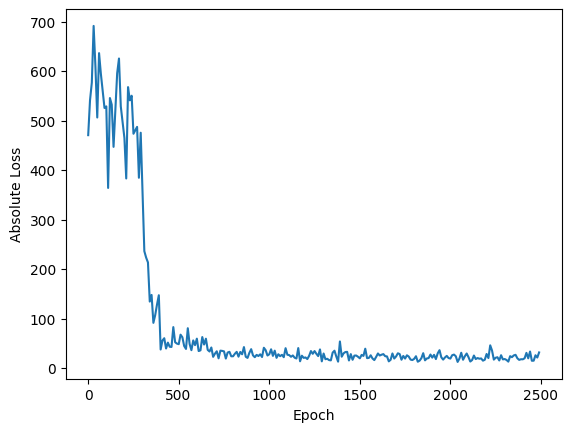

In [16]:
epochs = np.arange(1,2501,10)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses)

Evaluate and compare random example's predicted value vs real value:

In [22]:
x,y = generate_data(-100,100,1)

with torch.no_grad():
    model.eval()
    y_pred = model(x)
l1 = criterion(y_pred,y).item()

print(f'x1, x2 = {x[0][0]:.7f}, {x[0][1]:.7f}')
print(f'Predicted vs Actual value: {y_pred[0][0]} vs {y[0][0]}')
print(f'Test L1 Loss: {l1:.7f}')

x1, x2 = -19.9634933, 46.9810028
Predicted vs Actual value: -935.3321533203125 vs -937.904963868763
Test L1 Loss: 2.5728105


Generate 100 random samples to test and evaluate average loss within range of training data:

In [29]:
x_val,y_val = generate_data(-100,100,100)
model.eval()

total_loss = 0
for i in range(100):
    with torch.no_grad():
        y_pred = model(x_val[i])
        l1 = criterion(y_pred,y_val[i])
    total_loss+=l1

print(f'Average loss within range of training data = {total_loss/100:.7f}')

Average loss within range of training data = 23.9422534


Generate 100 random samples outside range of training data and calculate average loss:

In [41]:
x_test_neg,y_test_neg = generate_data(-500,-100,50)
x_test_pos,y_test_pos = generate_data(100.01,500,50)

total_loss = 0
for i in range(50):
    with torch.no_grad():
        y_pred = model(x_test_neg[i])
        l1 = criterion(y_pred,y_test_neg[i])
    total_loss+=l1

for i in range(50):
    with torch.no_grad():
        y_pred = model(x_test_pos[i])
        l1 = criterion(y_pred,y_test_pos[i])
    total_loss+=l1

print(f'Average loss outside range of training data = {total_loss/100:.7f}')

Average loss outside range of training data = 43897.8263955


# Q5:

In [ ]:
# TODO: figure out a way to read the images and labels into arrays

In [ ]:
class ClocksDataset(Dataset):
    """Custom Clocks Dataset"""

    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]
    
    # TODO: implement this function
    def __getitem__(self,idx):
        return